# Healthcare Data Analysis & Modeling

In this notebook, we analyze clinical and financial data of patients hospitalized for a certain condition.
Our main goal is to study what factors affect hospital admission costs. 

After preprocessing the data, explanatory data analysis is conducted. 
Predictive models (random forest regression and neural network) are then built to predict hospital admission costs.  

## Initializing

In [1]:
import numpy as np 
import pandas as pd
import math 
import re
import imblearn
import shap
import seaborn as sns
import missingno as msno
import matplotlib.patches as mpatches
import matplotlib.colors as colors

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from IPython.display import display
from imblearn.over_sampling import SMOTE
from datetime import datetime
from shap import TreeExplainer
from dateutil.relativedelta import relativedelta
from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, accuracy_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.pipeline import make_pipeline


In [2]:
#colormap
holmuskblue3 = '#526ca9'
holmuskbg = '#eef0f7'

holmuskpalette_light = ['#dde2ee', '#bac5de', '#98a8cd', '#758bbd', '#536eac', '#4b639b']
holmuskpalette_diverse = ['#bac5de', '#758bbd', '#3a4d78', '#212c45']

In [3]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

### Helper functions

In [4]:
#sets monetary values to plot axis 
def monetary_ticks(value, tick_number):
    return f'{value/1000:,.0f}'+'k'

## View the Data

Dataset consists of 4 separate .csv files that we join together later.

In [5]:
bill_amount_df = pd.read_csv('raw_data/bill_amount.csv')
bill_id_df = pd.read_csv('raw_data/bill_id.csv')
clinical_data_df = pd.read_csv('raw_data/clinical_data.csv')
demographics_df = pd.read_csv('raw_data/demographics.csv')

In [6]:
display(bill_amount_df.head())
display(bill_id_df.head())
display(clinical_data_df.head())
display(demographics_df.head())

,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351
3,3818426276,755.965425
4,9833541918,897.347816


,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01


,id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,1d21f2be18683991eb93d182d6b2d220,2011-01-01,2011-01-11,0,1.0,0,0,0.0,0,0,1,0,1,0,0,1,0,0,0,1,1,13.2,30.9,123.0,71.3,161.0
1,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01,2011-01-11,0,0.0,0,0,0.0,0,0,0,1,1,1,1,0,0,0,1,1,1,13.8,22.6,89.0,78.4,160.0
2,c85cf97bc6307ded0dd4fef8bad2fa09,2011-01-02,2011-01-13,0,0.0,0,0,0.0,0,0,0,1,1,1,1,1,1,1,1,1,0,11.2,26.2,100.0,72.0,151.0
3,e0397dd72caf4552c5babebd3d61736c,2011-01-02,2011-01-14,0,1.0,No,0,0.0,1,1,1,0,1,0,0,1,1,1,1,1,1,13.3,28.4,76.0,64.4,152.0
4,94ade3cd5f66f4584902554dff170a29,2011-01-08,2011-01-16,0,0.0,No,0,0.0,1,1,0,0,0,0,1,0,0,1,0,1,0,12.0,27.8,87.0,55.6,160.0


,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


In [7]:
clinical_data_df.isnull().sum()

id                      0
date_of_admission       0
date_of_discharge       0
medical_history_1       0
medical_history_2     233
medical_history_3       0
medical_history_4       0
medical_history_5     304
medical_history_6       0
medical_history_7       0
preop_medication_1      0
preop_medication_2      0
preop_medication_3      0
preop_medication_4      0
preop_medication_5      0
preop_medication_6      0
symptom_1               0
symptom_2               0
symptom_3               0
symptom_4               0
symptom_5               0
lab_result_1            0
lab_result_2            0
lab_result_3            0
weight                  0
height                  0
dtype: int64

## Preparing the data
Changing data types and recoding variables. 

In [8]:
bill_id_df = bill_id_df.astype({'patient_id':str, 'date_of_admission':'datetime64'})
clinical_data_df = clinical_data_df.astype({'date_of_admission':'datetime64', 'date_of_discharge':'datetime64'})

In [9]:
clinical_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3400 non-null   object        
 1   date_of_admission   3400 non-null   datetime64[ns]
 2   date_of_discharge   3400 non-null   datetime64[ns]
 3   medical_history_1   3400 non-null   int64         
 4   medical_history_2   3167 non-null   float64       
 5   medical_history_3   3400 non-null   object        
 6   medical_history_4   3400 non-null   int64         
 7   medical_history_5   3096 non-null   float64       
 8   medical_history_6   3400 non-null   int64         
 9   medical_history_7   3400 non-null   int64         
 10  preop_medication_1  3400 non-null   int64         
 11  preop_medication_2  3400 non-null   int64         
 12  preop_medication_3  3400 non-null   int64         
 13  preop_medication_4  3400 non-null   int64       

In [10]:
clinical_data_df.replace('No', 0, inplace = True)
clinical_data_df.replace('Yes', 1, inplace = True)
clinical_data_df[clinical_data_df.columns[3:26]] = clinical_data_df[clinical_data_df.columns[3:26]].astype(float)
clinical_data_df = clinical_data_df.rename(columns={'id': 'patient_id'})

In [11]:
demographics_df= demographics_df.astype({'patient_id':str, 'gender':str, 'race':str, 'resident_status':str, 'date_of_birth':'datetime64'})
demographics_df.gender.replace({'Female': 'f', 'Male':'m'}, inplace = True)
demographics_df.race.replace({'chinese': 'Chinese', 'India':'Indian', 'Others':'Other'}, inplace = True)

## Joining the datasets 
We join the 4 data files into 1 based on patient_id. As a result, we get data on admission level.  

In [12]:
# join bill_amount_df and bill_id_df on bill_id: 
financials_df = pd.merge(bill_id_df, bill_amount_df, on='bill_id', how = 'left')

#join clinical_data_df on financial_df on patient_id
medical_financials_df = pd.merge(financials_df, clinical_data_df, on=['patient_id', 'date_of_admission'])

#join demographics_df to medical_financials_df on patient_id
df = pd.merge(demographics_df, medical_financials_df, on='patient_id')
df

,patient_id,gender,race,resident_status,date_of_birth,bill_id,date_of_admission,amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,fa2d818b2261e44e30628ad1ac9cc72c,f,Indian,Singaporean,1971-05-14,3681463207,2014-09-20,16079.726035,2014-10-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,14.2,27.0,81.0,68.1,161.0
1,fa2d818b2261e44e30628ad1ac9cc72c,f,Indian,Singaporean,1971-05-14,9275762695,2014-09-20,614.011832,2014-10-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,14.2,27.0,81.0,68.1,161.0
2,fa2d818b2261e44e30628ad1ac9cc72c,f,Indian,Singaporean,1971-05-14,6620751760,2014-09-20,1324.103110,2014-10-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,14.2,27.0,81.0,68.1,161.0
3,fa2d818b2261e44e30628ad1ac9cc72c,f,Indian,Singaporean,1971-05-14,3065454316,2014-09-20,1546.325288,2014-10-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,14.2,27.0,81.0,68.1,161.0
4,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18,6471502938,2014-08-08,18323.719449,2014-08-18,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,14.3,27.2,92.0,76.5,151.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13595,c5ca8e8bfd744a1ef6f77318bcb591b4,f,Chinese,Singaporean,1973-04-19,9927801295,2011-09-02,5540.449960,2011-09-11,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,13.2,27.7,103.0,94.4,159.0
13596,20b609609d4dbb834d722ddf29f18879,m,Chinese,Singaporean,1986-09-04,4349734739,2015-06-19,806.323657,2015-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,18.4,25.9,111.0,87.1,167.0
13597,20b609609d4dbb834d722ddf29f18879,m,Chinese,Singaporean,1986-09-04,9578216913,2015-06-19,561.348095,2015-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,18.4,25.9,111.0,87.1,167.0
13598,20b609609d4dbb834d722ddf29f18879,m,Chinese,Singaporean,1986-09-04,1873862440,2015-06-19,12481.778272,2015-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,18.4,25.9,111.0,87.1,167.0


In [13]:
#grouping to admission level data
f = {'gender':'first',
     'race':'first',
     'resident_status':'first',
     'date_of_birth':'first',
     'amount' : 'sum', 
     'date_of_discharge': 'first',
     'medical_history_1': 'first', 
     'medical_history_2':'first', 
     'medical_history_3':'first', 
     'medical_history_4':'first', 
     'medical_history_5': 'first', 
     'medical_history_6':'first', 
     'medical_history_7':'first', 
     'preop_medication_1':'first', 
     'preop_medication_2': 'first', 
     'preop_medication_3': 'first', 
     'preop_medication_4':'first', 
     'preop_medication_5':'first', 
     'preop_medication_6':'first', 
     'symptom_1':'first', 
     'symptom_2':'first', 
     'symptom_3':'first', 
     'symptom_4':'first', 
     'symptom_5':'first', 
     'lab_result_1':'first', 
     'lab_result_2':'first', 
     'lab_result_3':'first', 
     'weight':'first',
     'height':'first'
    }

df = df.groupby(['patient_id', 'date_of_admission']).agg(f)
df = df.reset_index()
df.head()

,patient_id,date_of_admission,gender,race,resident_status,date_of_birth,amount,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
0,00225710a878eff524a1d13be817e8e2,2014-04-10,f,Chinese,Singaporean,1983-01-16,5190.566695,2014-04-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.4,27.9,96.0,66.9,155.0
1,0029d90eb654699c18001c17efb0f129,2012-11-07,f,Chinese,Singaporean,1943-10-14,22601.497872,2012-11-20,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,16.7,26.5,109.0,89.1,160.0
2,0040333abd68527ecb53e1db9073f52e,2013-01-19,m,Indian,Singaporean,1972-08-26,17447.181635,2013-01-31,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.8,25.2,96.0,79.5,172.0
3,00473b58e3dc8ae37b3cb34069705083,2014-02-10,f,Chinese,Singapore citizen,1976-07-23,15285.883220,2014-02-15,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,14.9,28.7,122.0,81.1,160.0
4,0078662d1d983dde68ea057c42d5b5cf,2012-04-28,m,Malay,Foreigner,1942-10-19,73477.869010,2012-05-10,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,14.2,27.2,89.0,74.7,173.0


### Feature Engineering

We add features age_on_admission, length_of_stay, total_admissions, BMI_value and BMI_class (based on Asia-Pacific BMI). 

In [14]:
#add columns for age in years on admission: 
days_in_year = 365.2425   
df['age_on_admission'] =((df.date_of_admission - df.date_of_birth).dt.days / days_in_year).astype(int)

#add column for length of stay in days: 
df['length_of_stay'] = (df.date_of_discharge - df.date_of_admission).dt.days

#add column for total number of admissions in 2011-2015
df['total_admissions'] = df.groupby('patient_id').patient_id.transform('count')

#creating BMI_value and BMI_class columns using Asia-Pacific body mass index
df['BMI_value'] = df.weight / (df.height/100)**2
df['BMI_class'] = None
df['BMI_class'].mask(df['BMI_value']<18.5, 'underweight', inplace=True)
df['BMI_class'].mask(df['BMI_value']>=18.5,'normal', inplace = True) 
df['BMI_class'].mask(df['BMI_value']>=23, 'overweight', inplace = True) 
df['BMI_class'].mask(df['BMI_value']>=25, 'obese', inplace = True) 

In [15]:
#arrange columns
df = df[['patient_id',
 'date_of_birth',
 'gender',
 'race',
 'resident_status',
 'weight',
 'height',
 'BMI_value',
 'BMI_class',
 'age_on_admission',
 'date_of_admission',
 'date_of_discharge',
 'length_of_stay',
 'total_admissions',
 'amount',
 'medical_history_1',
 'medical_history_2',
 'medical_history_3',
 'medical_history_4',
 'medical_history_5',
 'medical_history_6',
 'medical_history_7',
 'preop_medication_1',
 'preop_medication_2',
 'preop_medication_3',
 'preop_medication_4',
 'preop_medication_5',
 'preop_medication_6',
 'symptom_1',
 'symptom_2',
 'symptom_3',
 'symptom_4',
 'symptom_5',
 'lab_result_1',
 'lab_result_2',
 'lab_result_3'
]]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          3400 non-null   object        
 1   date_of_birth       3400 non-null   datetime64[ns]
 2   gender              3400 non-null   object        
 3   race                3400 non-null   object        
 4   resident_status     3400 non-null   object        
 5   weight              3400 non-null   float64       
 6   height              3400 non-null   float64       
 7   BMI_value           3400 non-null   float64       
 8   BMI_class           3400 non-null   object        
 9   age_on_admission    3400 non-null   int64         
 10  date_of_admission   3400 non-null   datetime64[ns]
 11  date_of_discharge   3400 non-null   datetime64[ns]
 12  length_of_stay      3400 non-null   int64         
 13  total_admissions    3400 non-null   int64       

In [17]:
#missing values %
1-len(df.dropna())/len(df)

0.14764705882352946

In [18]:
#describe patient_level data (first admission)
patients = df.sort_values('date_of_admission').groupby('patient_id').agg('first').describe() 
patients

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,2820.000000,3000.000000,3000.000000,2765.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000
mean,78.778533,165.126333,28.955222,51.894333,11.078667,1.133333,21798.335703,0.166333,0.308511,0.136667,0.052333,0.063291,0.249667,0.256000,0.500000,0.587667,0.820333,0.519667,0.820667,0.739333,0.620333,0.659667,0.547667,0.722000,0.525667,14.478500,27.44390,99.566000
std,10.992955,7.004193,4.144775,14.664021,2.855497,0.360923,10161.000119,0.372442,0.461960,0.343552,0.222735,0.243530,0.432892,0.436495,0.500083,0.492337,0.383974,0.499696,0.383695,0.439072,0.485385,0.473900,0.497806,0.448088,0.499424,1.754043,2.46608,15.138781
min,48.000000,151.000000,17.508651,21.000000,1.000000,1.000000,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.70000,52.000000
25%,71.175000,160.000000,26.161927,39.000000,9.000000,1.000000,14665.890997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.200000,25.80000,88.000000
50%,78.900000,165.000000,28.921908,50.000000,11.000000,1.000000,20101.522184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.40000,100.000000
75%,86.300000,170.000000,31.675212,64.000000,13.000000,1.000000,26733.192619,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.800000,29.20000,110.000000
max,121.000000,186.000000,46.677349,85.000000,20.000000,4.000000,98120.870207,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.10000,146.000000


In [19]:
#describe admission level data
admissions = df.select_dtypes(include=[np.float64, int]).describe()
admissions

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3167.000000,3400.000000,3400.000000,3096.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,78.748441,165.084412,28.958874,52.039412,11.051176,1.248235,21859.071130,0.169118,0.311336,0.136176,0.052059,0.063953,0.254706,0.254412,0.503824,0.591176,0.820882,0.523235,0.819706,0.744118,0.619706,0.662353,0.544706,0.726471,0.526765,14.469882,27.431529,99.489706
std,10.975076,6.973678,4.140674,14.698327,2.850140,0.476728,10155.336753,0.374911,0.463113,0.343026,0.222178,0.244710,0.435760,0.435594,0.500059,0.491689,0.383507,0.499533,0.384489,0.436420,0.485530,0.472977,0.498071,0.445836,0.499357,1.747323,2.463844,15.254453
min,48.000000,151.000000,17.508651,21.000000,1.000000,1.000000,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,52.000000
25%,71.200000,160.000000,26.156074,39.000000,9.000000,1.000000,14793.370831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.200000,25.800000,88.000000
50%,78.900000,165.000000,28.943985,50.000000,11.000000,1.000000,20180.020614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.400000,100.000000
75%,86.300000,170.000000,31.713345,64.250000,13.000000,1.000000,26680.292435,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.800000,29.100000,110.000000
max,121.000000,186.000000,46.677349,85.000000,20.000000,4.000000,98723.854994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.100000,150.000000


In [20]:
#describe admission level data, men
describe_m = df[df.gender == 'm'][admissions.columns].describe()
describe_m

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1586.000000,1698.000000,1698.000000,1548.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000
mean,82.950530,170.040636,28.755061,52.198469,10.951119,1.239105,22446.032462,0.163133,0.306431,0.138398,0.047703,0.056202,0.273852,0.237338,0.500000,0.586572,0.826266,0.504711,0.808598,0.748528,0.623675,0.654299,0.560660,0.736160,0.533569,14.433039,27.421437,99.631920
std,10.170192,4.870279,3.857861,14.783611,2.804885,0.462452,10295.352689,0.369596,0.461156,0.345419,0.213200,0.230385,0.446065,0.425577,0.500147,0.492593,0.378992,0.500125,0.393520,0.433987,0.484606,0.475736,0.496453,0.440843,0.499019,1.734851,2.468971,15.163244
min,56.000000,161.000000,18.724174,21.000000,2.000000,1.000000,4027.726961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,20.200000,57.000000
25%,76.300000,166.000000,26.063155,39.000000,9.000000,1.000000,15234.303392,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.100000,25.700000,88.000000
50%,83.100000,170.000000,28.799351,50.000000,11.000000,1.000000,21063.894017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.400000,27.400000,100.000000
75%,90.100000,173.000000,31.363417,65.000000,13.000000,1.000000,27168.156055,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.700000,29.100000,110.000000
max,121.000000,186.000000,40.900487,85.000000,20.000000,4.000000,98723.854994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,18.900000,35.100000,150.000000


In [21]:
#describe admission level data, women
describe_f = df[df.gender == 'f'][admissions.columns].describe()
describe_f

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1581.000000,1702.000000,1702.000000,1548.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000,1702.000000
mean,74.556228,160.139835,29.162208,51.880729,11.150999,1.257344,21273.489261,0.175088,0.316256,0.133960,0.056404,0.071705,0.235605,0.271445,0.507638,0.595770,0.815511,0.541716,0.830787,0.739718,0.615746,0.670388,0.528790,0.716804,0.519976,14.506639,27.441598,99.347826
std,10.113911,4.952848,4.396498,14.615366,2.891959,0.490523,9982.373541,0.380154,0.465161,0.340709,0.230768,0.258083,0.424501,0.444836,0.500089,0.490887,0.387996,0.498403,0.375050,0.438917,0.486561,0.470210,0.499317,0.450683,0.499748,1.759418,2.459403,15.348051
min,48.000000,151.000000,17.508651,21.000000,1.000000,1.000000,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,52.000000
25%,67.800000,157.000000,26.265665,39.000000,9.000000,1.000000,14458.248630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.300000,25.800000,88.000000
50%,74.700000,160.000000,29.132744,50.000000,11.000000,1.000000,19521.562498,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.450000,100.000000
75%,81.200000,164.000000,31.925973,64.000000,13.000000,1.000000,26410.583656,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.800000,29.200000,110.000000
max,110.700000,174.000000,46.677349,84.000000,20.000000,3.000000,88873.627994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.000000,146.000000


In [22]:
#count mean admission cost/day
a = df
a['cost_per_day'] = a.amount/a.length_of_stay
print(a.cost_per_day.mean())
a.drop('cost_per_day', axis = 1, inplace = True)

2146.372577209576


In [23]:
#count mean average admission cost/day/patient for women
patients_f = df[df.gender == 'f'].sort_values('date_of_admission').groupby('patient_id').agg('sum').describe() 
patients_f

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3
count,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000,1497.000000
mean,84.765999,182.069472,33.155697,58.985304,12.678023,1.429526,24186.692533,0.199065,0.334001,0.152305,0.064128,0.074148,0.267869,0.308617,0.577154,0.677355,0.927188,0.615898,0.944556,0.841015,0.700067,0.762191,0.601202,0.814963,0.591182,16.493186,31.199466,112.952572
std,30.123719,59.806041,11.940609,26.135671,5.029778,1.216205,13744.941994,0.406069,0.489870,0.361291,0.245063,0.264638,0.462197,0.484671,0.570755,0.567127,0.500710,0.577046,0.498928,0.560606,0.565455,0.580049,0.550230,0.568646,0.555601,5.669988,10.488713,39.849949
min,48.000000,151.000000,17.508651,21.000000,1.000000,1.000000,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.900000,52.000000
25%,68.700000,157.000000,26.620782,40.000000,9.000000,1.000000,15215.229743,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.500000,26.100000,90.000000
50%,76.600000,161.000000,29.939059,54.000000,12.000000,1.000000,21072.923098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.900000,27.900000,103.000000
75%,85.400000,166.000000,33.789062,69.000000,14.000000,1.000000,29293.819847,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.500000,30.200000,116.000000
max,252.000000,504.000000,104.697251,223.000000,36.000000,9.000000,167641.308465,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,47.200000,90.900000,335.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3400 entries, 0 to 3399
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          3400 non-null   object        
 1   date_of_birth       3400 non-null   datetime64[ns]
 2   gender              3400 non-null   object        
 3   race                3400 non-null   object        
 4   resident_status     3400 non-null   object        
 5   weight              3400 non-null   float64       
 6   height              3400 non-null   float64       
 7   BMI_value           3400 non-null   float64       
 8   BMI_class           3400 non-null   object        
 9   age_on_admission    3400 non-null   int64         
 10  date_of_admission   3400 non-null   datetime64[ns]
 11  date_of_discharge   3400 non-null   datetime64[ns]
 12  length_of_stay      3400 non-null   int64         
 13  total_admissions    3400 non-null   int64       

## Explanatory Data Analysis 

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


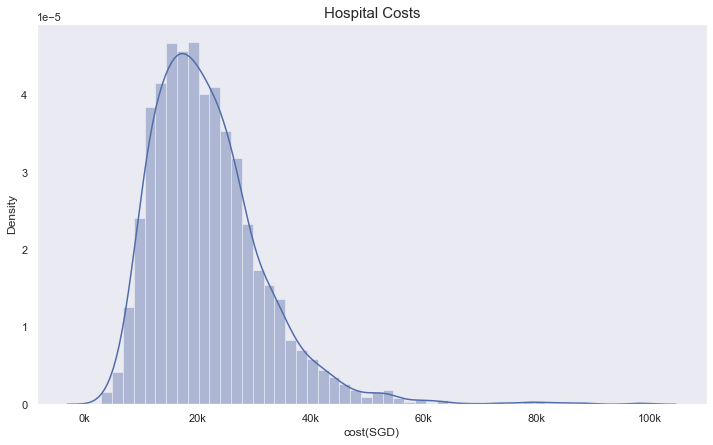

In [25]:
#Hospital costs
sns.set_theme()
plt.figure(figsize = (12,7))
ax = sns.distplot(x=df.amount, color = holmuskblue3)

ax.xaxis.set_major_formatter(FuncFormatter(monetary_ticks))
ax.set_xlabel('cost(SGD)')
ax.set_title('Hospital Costs', fontsize = 15)

ax.grid(False)

The admission cost distribution is sligthly right-skewed. From the previous describe_all, describe_m and describe_f tables we can see that the mean of admission cost is 21,9k. On average, men have more expensive admission costs (mean amount = 22,2k) compared to women (mean amount = 21,1k).

In [26]:
def plot_pie(data, column_name, title):
    d = data.groupby('patient_id').agg('first').reset_index()
    d = d[column_name].value_counts() / len(d[column_name])
    fig = plt.figure(figsize = (5,5))

    ax = fig.add_axes([10, 10, .8, .8], aspect=1)
    ax.pie(d, autopct = '%0.1f%%', labels = d.index, colors=sns.color_palette(holmuskpalette_light))
    ax.set_title(title, pad = 20, fontsize = 15)

    plt.show()

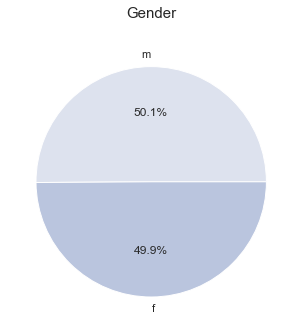

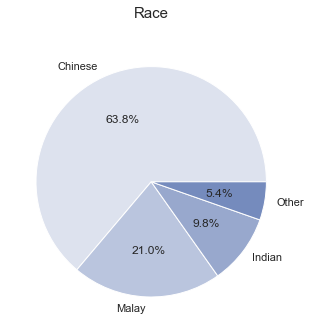

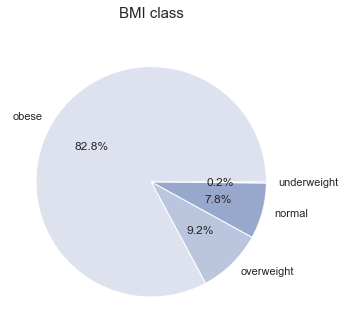

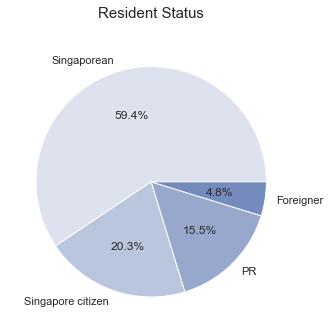

In [27]:
plot_pie(df, 'gender', 'Gender')
plot_pie(df, 'race', 'Race')
plot_pie(df, 'BMI_class', 'BMI class')
plot_pie(df, 'resident_status', 'Resident Status')

The gender distribution of the data was even. The patients were mostly Chinese (63.8% of the patients) and most of the patients' resident status was Singaporean (59.5% of the patients). Since majority of the patients were from Asia-Pacific countries, we used the Asia-Pacific body mass index (BMI) to compare the weights of the patients. There was siqnificant amount of obese patients in the data (82.8% of the patients). 

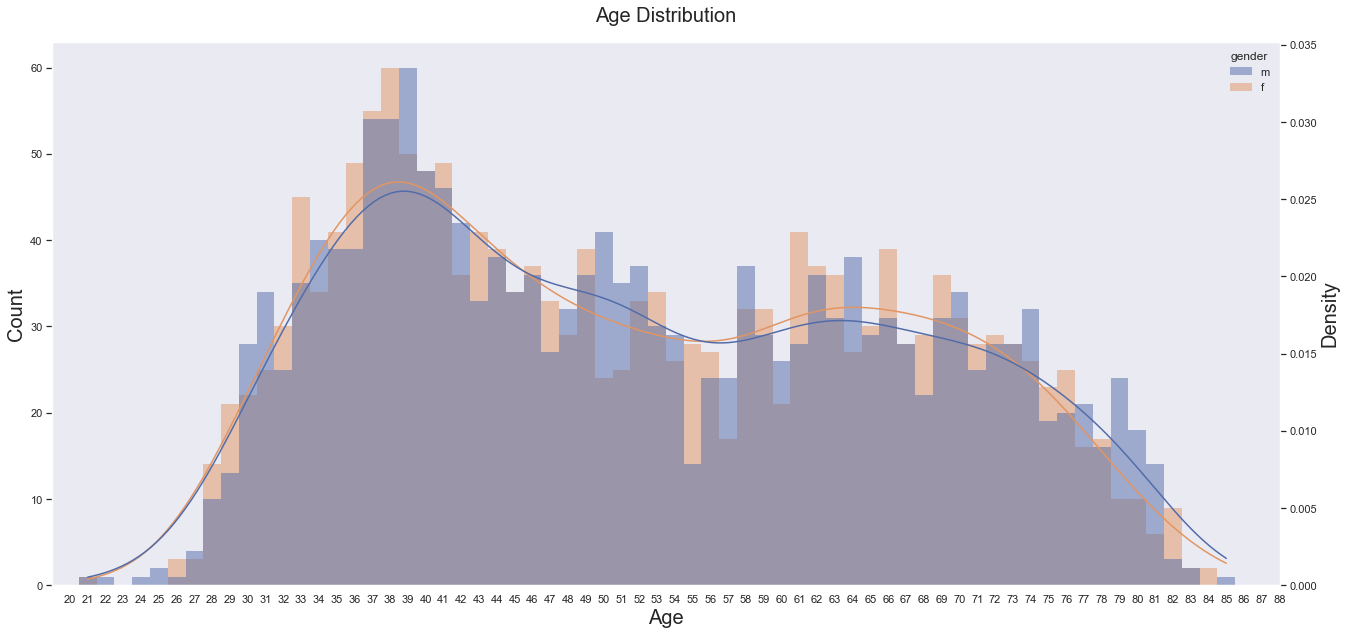

In [28]:
#age
sns.set_style({'axes.grid' : False})
holmuskpalette2 = [holmuskblue3, '#e29562']

fig, ax1 = plt.subplots(figsize = (22,10)) 
ax2 = ax1.twinx()

plt.rcParams['patch.linewidth'] = 0
sns.histplot(x = df.age_on_admission, bins = np.arange(90) - 0.5, ax = ax2, stat = 'density', alpha = 0.0) 
sns.histplot(x = df.age_on_admission, bins = np.arange(90) - 0.5, ax = ax1, stat = 'count', hue = df.gender, hue_order = ['m', 'f'], kde=True, palette = holmuskpalette2) 

ax1.set_xlabel('Age', fontsize = 20)
ax1.set_xticks(range(20,90,1))

ax1.set_ylabel('Count',  fontsize = 20)
ax2.set_ylabel('Density',  fontsize = 20)
ax2.set_title('Age Distribution', fontsize = 20, pad = 20)
plt.xlim([19, 88])

plt.show()


The age distribution on admission wasn't normally distributed. From the graph above we can see that there was relatively many admissions of patients aged 35-40 compared to other age groups and relatively few admission from patients aged 50-60. Some gender differences can also be seen: on the age group of over 74 years, there are more admissions of men than women. 

In [29]:
def plot_dist(df, column_name, title, bins):
    sns.set_theme()
    plt.figure(figsize = (12,7))
    ax = sns.distplot(x=df[column_name], color = holmuskblue3, bins = bins)
    ax.set_title(title, fontsize = 15)
    ax.grid(False)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


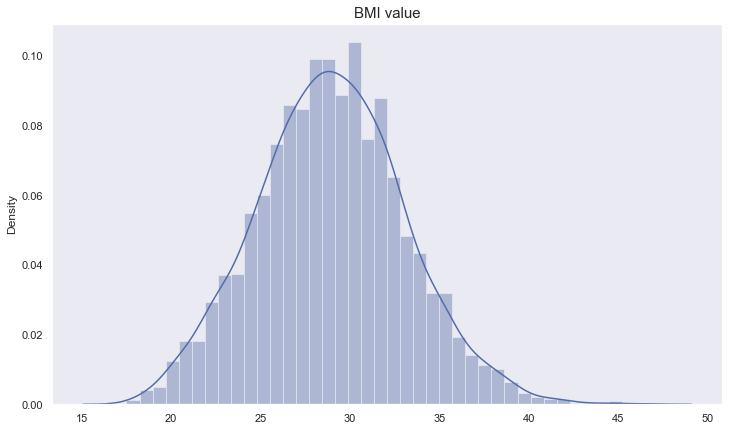

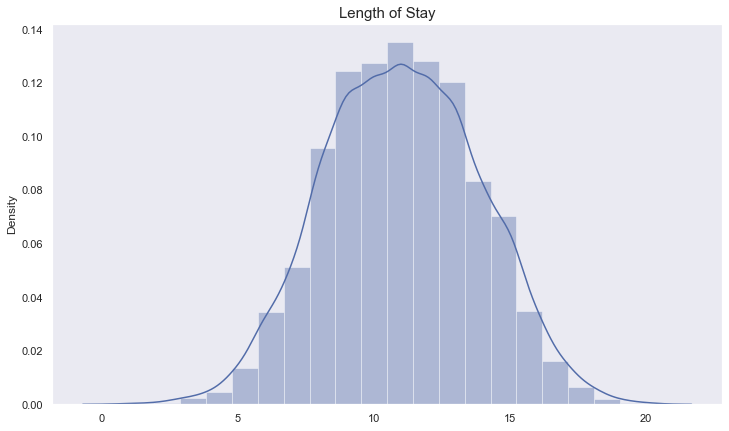

In [30]:
plot_dist(df, 'BMI_value', 'BMI value', bins = None)
plot_dist(df, 'length_of_stay', 'Length of Stay', len(df.length_of_stay.unique()))

Mean hospital admission length was 11 days and mean BMI of the patients 29.0.

Text(0.5, 0.98, 'Distribution of Laboratory Results')

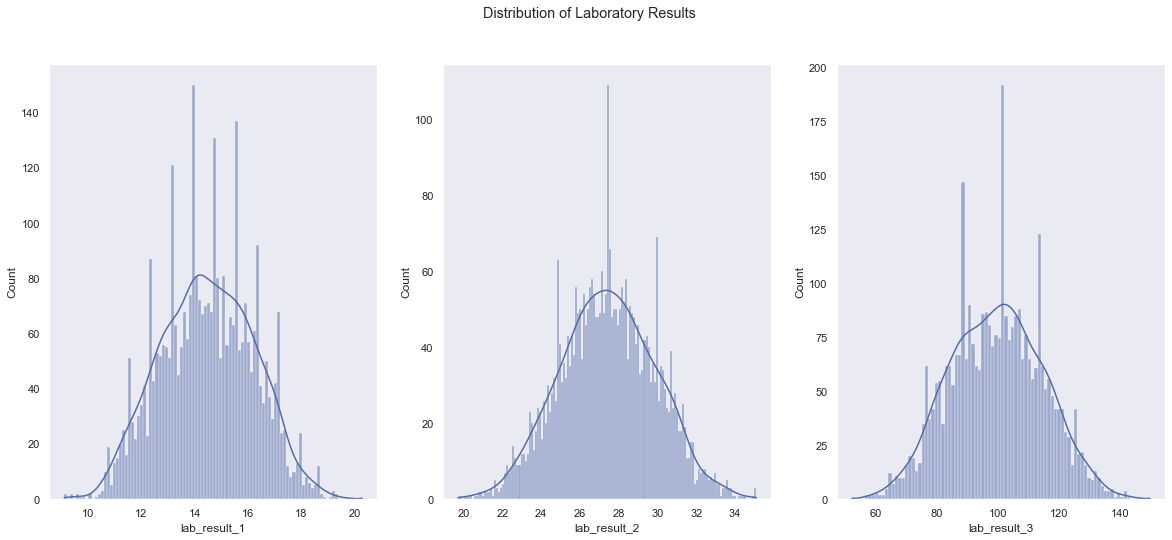

In [31]:
#lab_results
sns.set_theme()
plt.rcParams['axes.grid'] = False
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20,8))

sns.histplot(df['lab_result_1'], color = holmuskblue3, kde=True, ax=ax[0], bins = len(df.lab_result_1.unique()))
sns.histplot(df['lab_result_2'], color = holmuskblue3, kde=True,  ax=ax[1], bins = len(df.lab_result_2.unique()))
sns.histplot(df['lab_result_3'], color = holmuskblue3, kde=True, ax=ax[2], bins = len(df.lab_result_3.unique()))
 
fig.suptitle('Distribution of Laboratory Results')


In [32]:
#lab results statistics per patient on first admission 
patients_labs = df.sort_values('date_of_admission').groupby('patient_id').agg('mean')
patients_labs[['lab_result_1', 'lab_result_2', 'lab_result_3']].describe()

,lab_result_1,lab_result_2,lab_result_3
count,3000.000000,3000.000000,3000.000000
mean,14.472053,27.438483,99.503306
std,1.695727,2.371529,14.735463
min,9.100000,19.900000,52.000000
25%,13.300000,25.800000,89.000000
50%,14.500000,27.400000,100.000000
75%,15.700000,29.000000,110.000000
max,20.300000,35.100000,146.000000


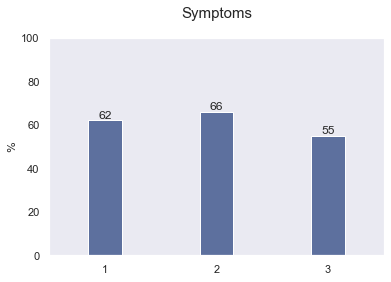

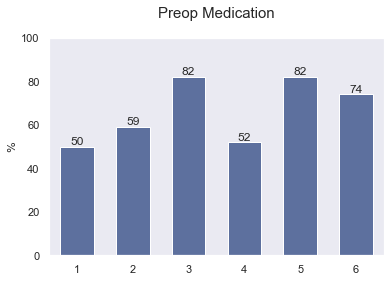

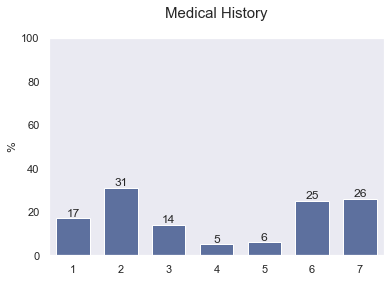

In [33]:
# Gets individual-level dataframe of categorical features. Counts percentual occurrence of each feature value. Null values excluded.
def plot_hist(data, title):
    
    values = []
    for column in data.columns: 
        v = len(data[data[column]==1]) / (len(data[column].dropna())) * 100
        values.append(round(v, 0))
        
    ax = sns.barplot(x=data.columns, y=values, color=colors.to_rgb(holmuskblue3), dodge=False)
    ax.set_xticklabels(range(1,len(data.columns)+1))
    ax.set_ylim(0,100)

    ax.set(ylabel='%', xlabel = None)
    ax.bar_label(ax.containers[0])
    ax.set_title(title, pad = 20, fontsize = 15)
    ax.grid(False)
    
    #resize and center bars
    for patch in ax.patches :
        new_value = len(data.columns) * 0.1
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)
    plt.show()


#individual level data  
ind_data = df.groupby(['patient_id']).agg('first').reset_index()

plot_hist(ind_data[['symptom_1', 'symptom_2', 'symptom_3']], 'Symptoms')
plot_hist(ind_data[['preop_medication_1', 'preop_medication_2', 'preop_medication_3', 'preop_medication_4', 'preop_medication_5','preop_medication_6']], 'Preop Medication')
plot_hist(ind_data[['medical_history_1', 'medical_history_2', 'medical_history_3', 'medical_history_4', 'medical_history_5', 'medical_history_6', 'medical_history_7']], 'Medical History')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


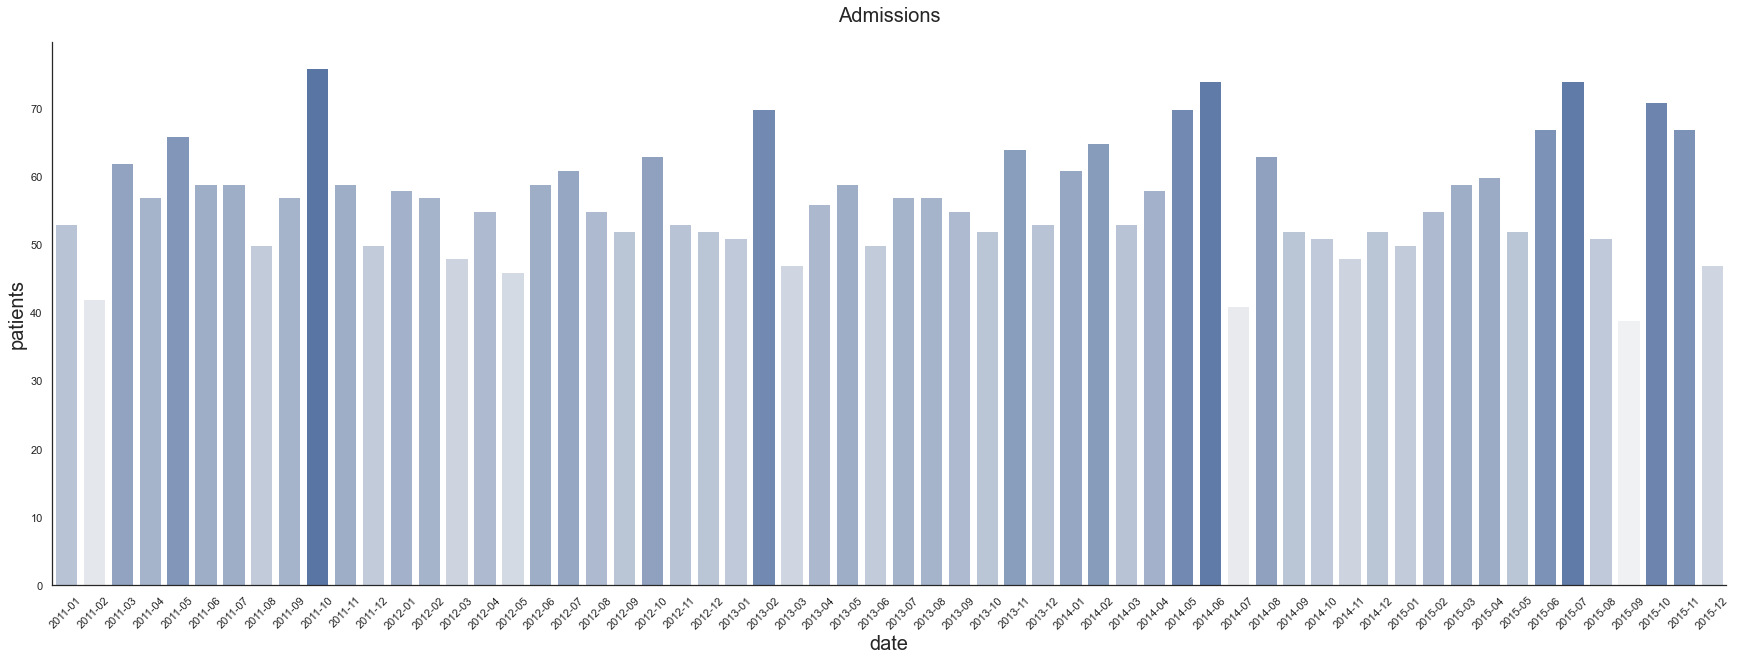

In [34]:
#all admissions 
data = df[['patient_id', 'date_of_admission']]
data.loc[:,'date_of_admission'] = pd.to_datetime(data['date_of_admission']).dt.strftime('%Y-%m')
data = data.groupby(by = 'date_of_admission').agg('count')
data.reset_index(inplace = True)
data.sort_values('date_of_admission', inplace = True)

dims = (30, 10)
sns.set_style("white")

def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

plt.figure(figsize = dims)
plt.xticks(rotation = 45)

ax = sns.barplot(data=data, x="date_of_admission", y="patient_id", palette=colors_from_values(data.patient_id, "light:b"))
ax.set_title('Admissions', fontsize = 20, pad = 20)
ax.set_ylabel('patients', fontsize = 20)
ax.set_xlabel('date', fontsize = 20)

sns.despine()



The data was collected between January 2011 and December 2015. Total admissions varied between 40 to 80 in a month, largest number of admissions being in October 2011. However, the trend should be taken with reservation since we don't know the sampling method of the data. 


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
FixedFormatter should only be used together with FixedLocator


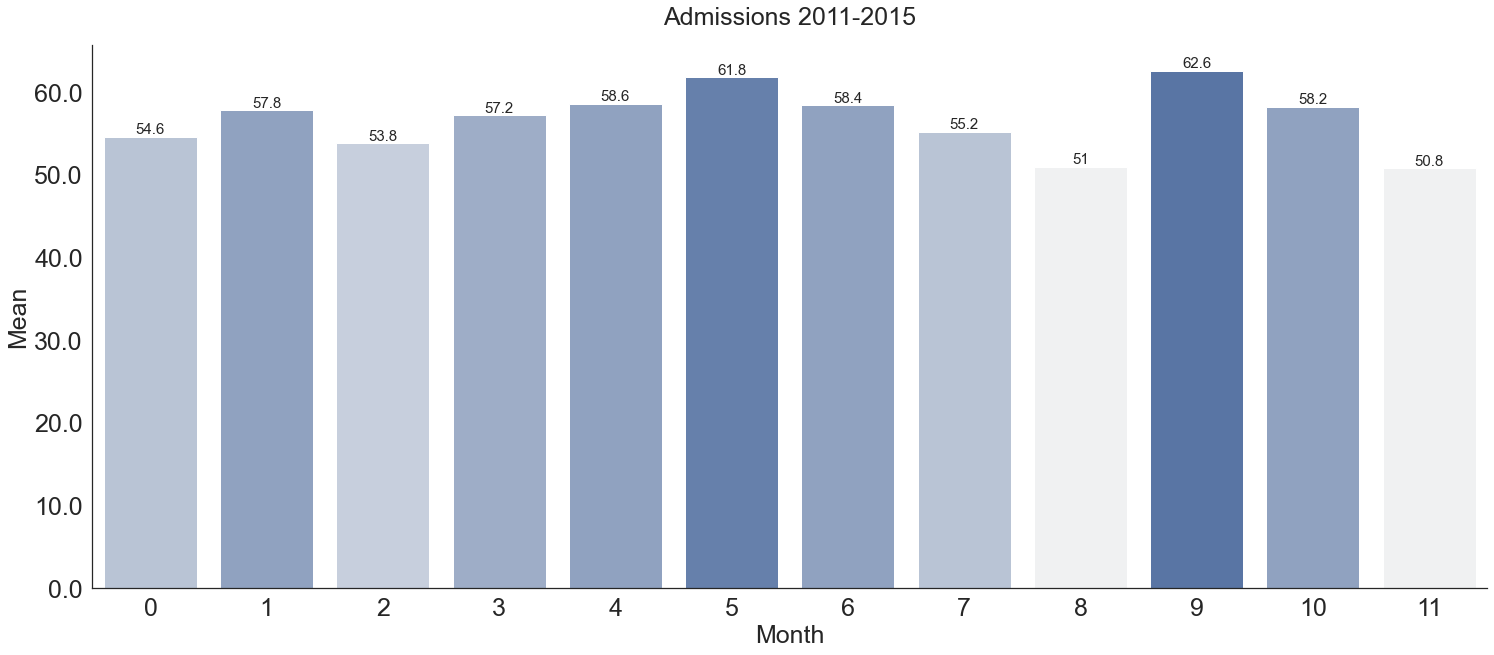

In [35]:
#month level aggreagated admissions
data = df[['patient_id', 'date_of_admission']]
data.loc[:, 'date_of_admission'] = pd.to_datetime(data.date_of_admission.dt.strftime('%Y-%m'))
data.loc[:,'year'] = data.date_of_admission.dt.year
data.loc[:, 'month'] = data.date_of_admission.dt.month

data = data.groupby(['year', 'month']).agg({'patient_id':'count'})
data = data.groupby(['month']).agg({'patient_id':'mean'})
data.rename(columns = {'patient_id':'patients_mean'}, inplace = True)
data.reset_index(inplace=True)

plt.figure(figsize = (25, 10))

ax = sns.barplot(data=data, x="month", y="patients_mean", palette=colors_from_values(data.patients_mean, "light:b"), ci = 'sd')
ax.set_title('Admissions 2011-2015', fontsize = 25, pad = 20)
ax.set_ylabel('Mean', fontsize = 25)
ax.set_xlabel('Month', fontsize = 25)
ax.set_yticklabels(ax.get_yticks(), size = 25)
ax.set_xticklabels(ax.get_xticks(), size = 25)

for container in ax.containers:
    ax.bar_label(container, fontsize = 15)
    
sns.despine()


During 2011-2015 there was most admissions in September and least in November. However, the trend should be taken with reservation since we don't know the sampling method of the data. 

## Missing Value Analysis 
To decide how to handle the missing values in medical_history_2 and medical_history_5, we conduct a missing value analysis. 

In [36]:
#missing value percentages
missing = pd.DataFrame()
missing['count'] = df.isna().sum()
missing['%'] = round(df.isna().sum().sort_values(ascending=False)/len(df) * 100, 2)
missing

,count,%
patient_id,0,0.00
date_of_birth,0,0.00
gender,0,0.00
race,0,0.00
resident_status,0,0.00
weight,0,0.00
height,0,0.00
BMI_value,0,0.00
BMI_class,0,0.00
age_on_admission,0,0.00


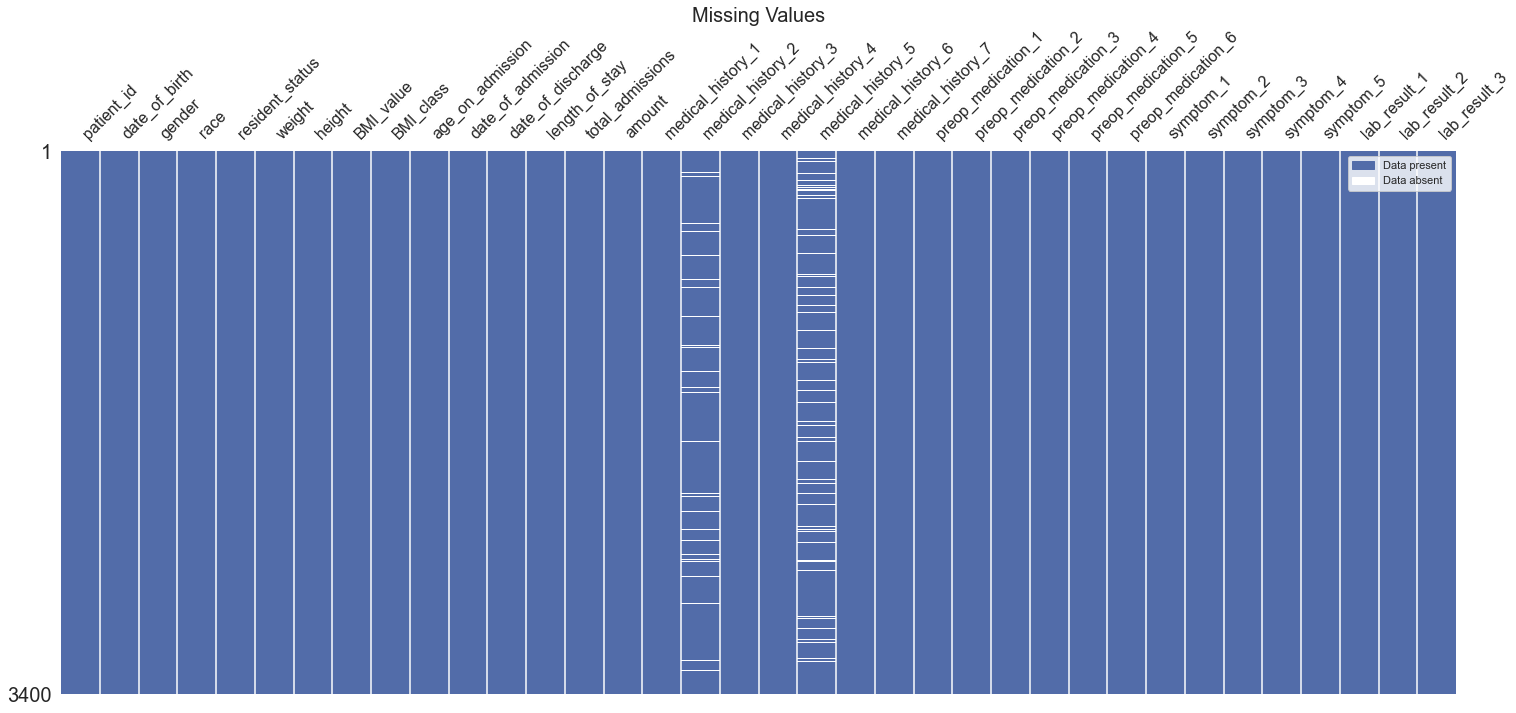

In [37]:
#missing data in the whole data set 
m = msno.matrix(df.sort_values('date_of_birth'), sparkline=False, color = colors.to_rgb(holmuskblue3))
gray = mpatches.Patch(color=holmuskblue3, label='Data present')
white = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[gray, white])
plt.title('Missing Values', fontsize=20)

plt.show()

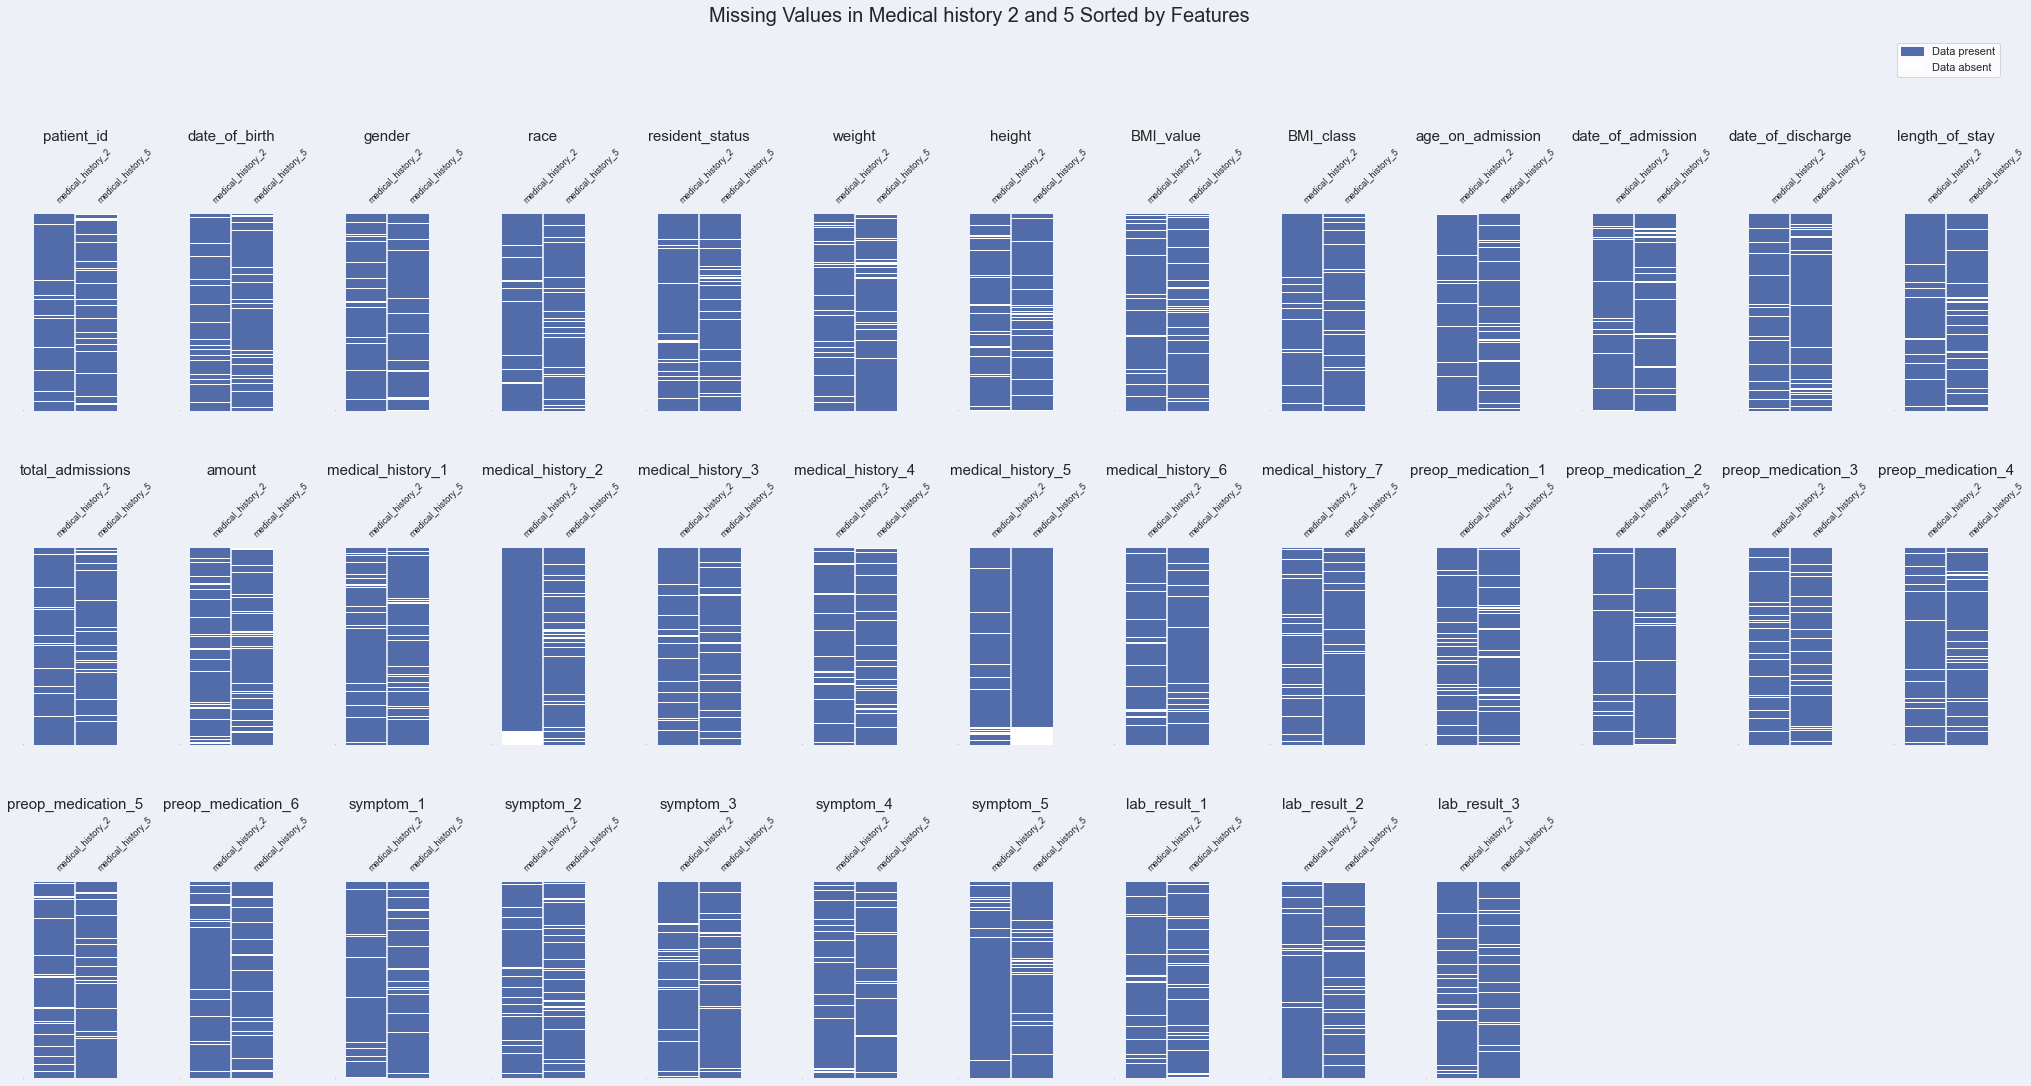

In [38]:
#missing data in medical_history_2 and medical_history_5, data sorted by features
nrows = 3
ncols = 13
fig, axes = plt.subplots(nrows,ncols, figsize=(35,16), facecolor=holmuskbg)
fig.suptitle("Missing Values in Medical history 2 and 5 Sorted by Features", fontsize=20)
plt.subplots_adjust(top = 0.8, bottom=0.05, hspace=0.7, wspace=0.9)


row = 0
col = 0
for column in df.columns[0:(nrows*ncols)]:
    a = df.sort_values(by = column)
    a = a[['medical_history_2', 'medical_history_5']]
    m = msno.matrix(a, sparkline=False, fontsize = 9, labels=True, color=colors.to_rgb(holmuskblue3), ax=axes[row, col])
    m.axes.tick_params(axis='y', labelsize = 0)
    m.axes.set_title(column, fontsize=15)
    
    if col < ncols-1: 
        col = col+1
    else: 
        col = 0
        row = row+1
        
axes[2,10].set_axis_off()
axes[2,11].set_axis_off()
axes[2,12].set_axis_off()


blue = mpatches.Patch(color=colors.to_rgb(holmuskblue3), label='Data present')
white = mpatches.Patch(color='white', label='Data absent ')
plt.legend(handles=[blue, white], loc = (-0.1, 5.1))

plt.show()


The missing values seem to not have connections to each other or to the features. Since missing values seem random and we don't know the data sampling method, meaning of features medical_history_2 and medical_history_5 and we don't know their distribution in population, we decide not to conduct imputations and instead delete the rows with missing data. 

In [39]:
#drop the empty values
df.dropna(inplace = True)

In [40]:
len(df)

2898

# Relationships of the features 

In [41]:
#dummies
df_dummies = pd.get_dummies(df[df.columns[1:]])
df_dummies.insert(loc = 0, column= 'patient_id', value = df.patient_id)
df_dummies.head()

,patient_id,date_of_birth,weight,height,BMI_value,age_on_admission,date_of_admission,date_of_discharge,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,gender_f,gender_m,race_Chinese,race_Indian,race_Malay,race_Other,resident_status_Foreigner,resident_status_PR,resident_status_Singapore citizen,resident_status_Singaporean,BMI_class_normal,BMI_class_obese,BMI_class_overweight,BMI_class_underweight
0,00225710a878eff524a1d13be817e8e2,1983-01-16,66.9,155.0,27.845994,31,2014-04-10,2014-04-22,12,1,5190.566695,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,13.4,27.9,96.0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
1,0029d90eb654699c18001c17efb0f129,1943-10-14,89.1,160.0,34.804687,69,2012-11-07,2012-11-20,13,1,22601.497872,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,16.7,26.5,109.0,1,0,1,0,0,0,0,0,0,1,0,1,0,0
2,0040333abd68527ecb53e1db9073f52e,1972-08-26,79.5,172.0,26.872634,40,2013-01-19,2013-01-31,12,1,17447.181635,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,14.8,25.2,96.0,0,1,0,1,0,0,0,0,0,1,0,1,0,0
3,00473b58e3dc8ae37b3cb34069705083,1976-07-23,81.1,160.0,31.679687,37,2014-02-10,2014-02-15,5,1,15285.883220,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,14.9,28.7,122.0,1,0,1,0,0,0,0,0,1,0,0,1,0,0
4,0078662d1d983dde68ea057c42d5b5cf,1942-10-19,74.7,173.0,24.959070,69,2012-04-28,2012-05-10,12,1,73477.869010,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,14.2,27.2,89.0,0,1,0,0,1,0,1,0,0,0,0,0,1,0


In [42]:
#drop redundant columns: 
df_dummies.drop('gender_f', axis = 1, inplace = True)

Text(0.5, 1.0, 'Correlation Heatmap')

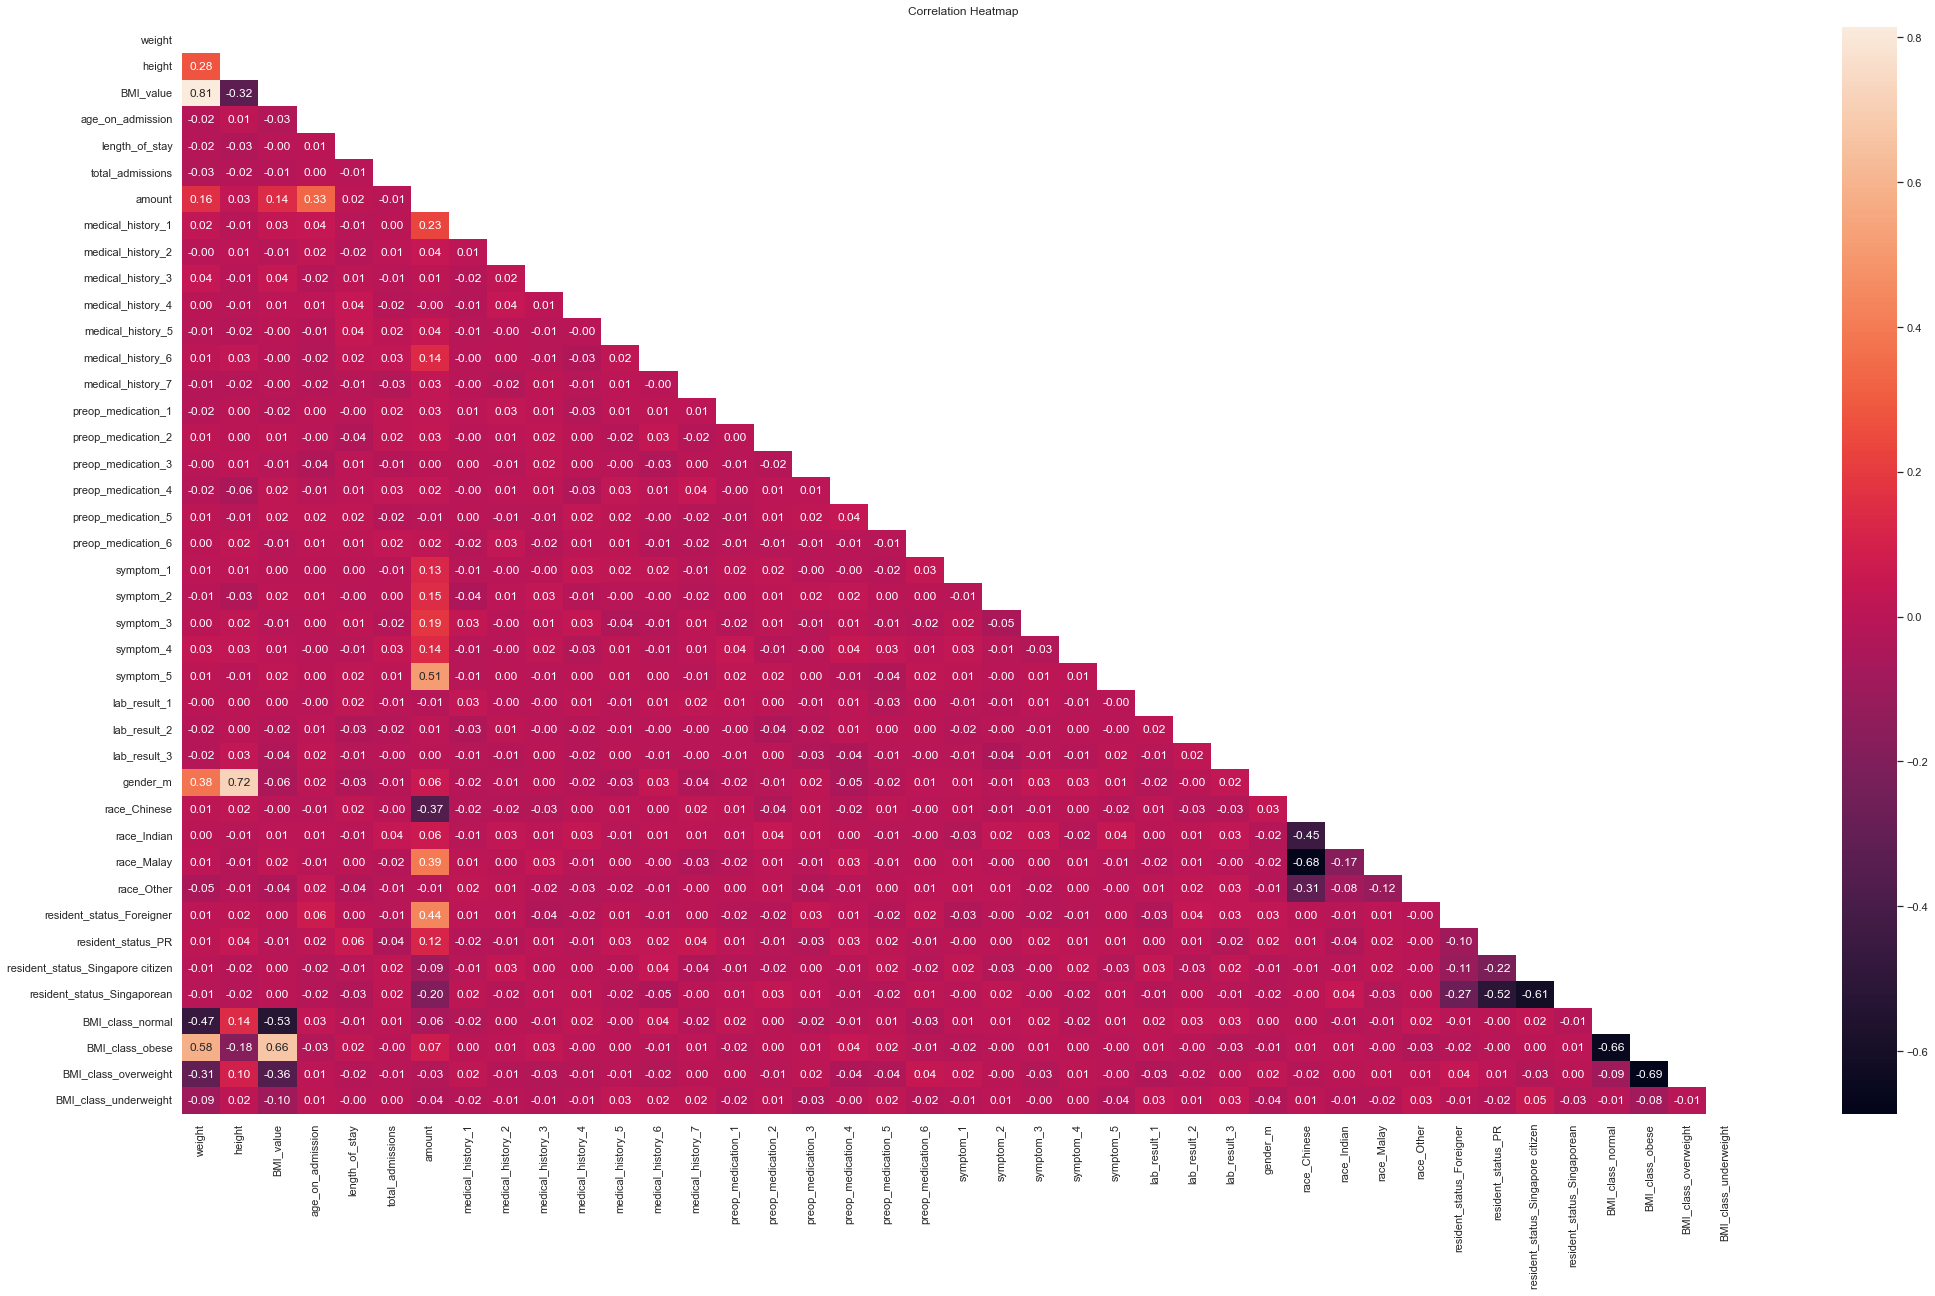

In [43]:
# Pearson correlation matrix and heatmap, all features: 
plt.figure(figsize=(35, 20))
mask = np.triu(np.ones_like(df_dummies.corr(method = 'pearson'), dtype=bool))
heatmap = sns.heatmap(df_dummies.corr(), annot=True, fmt=".2f", mask = mask)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

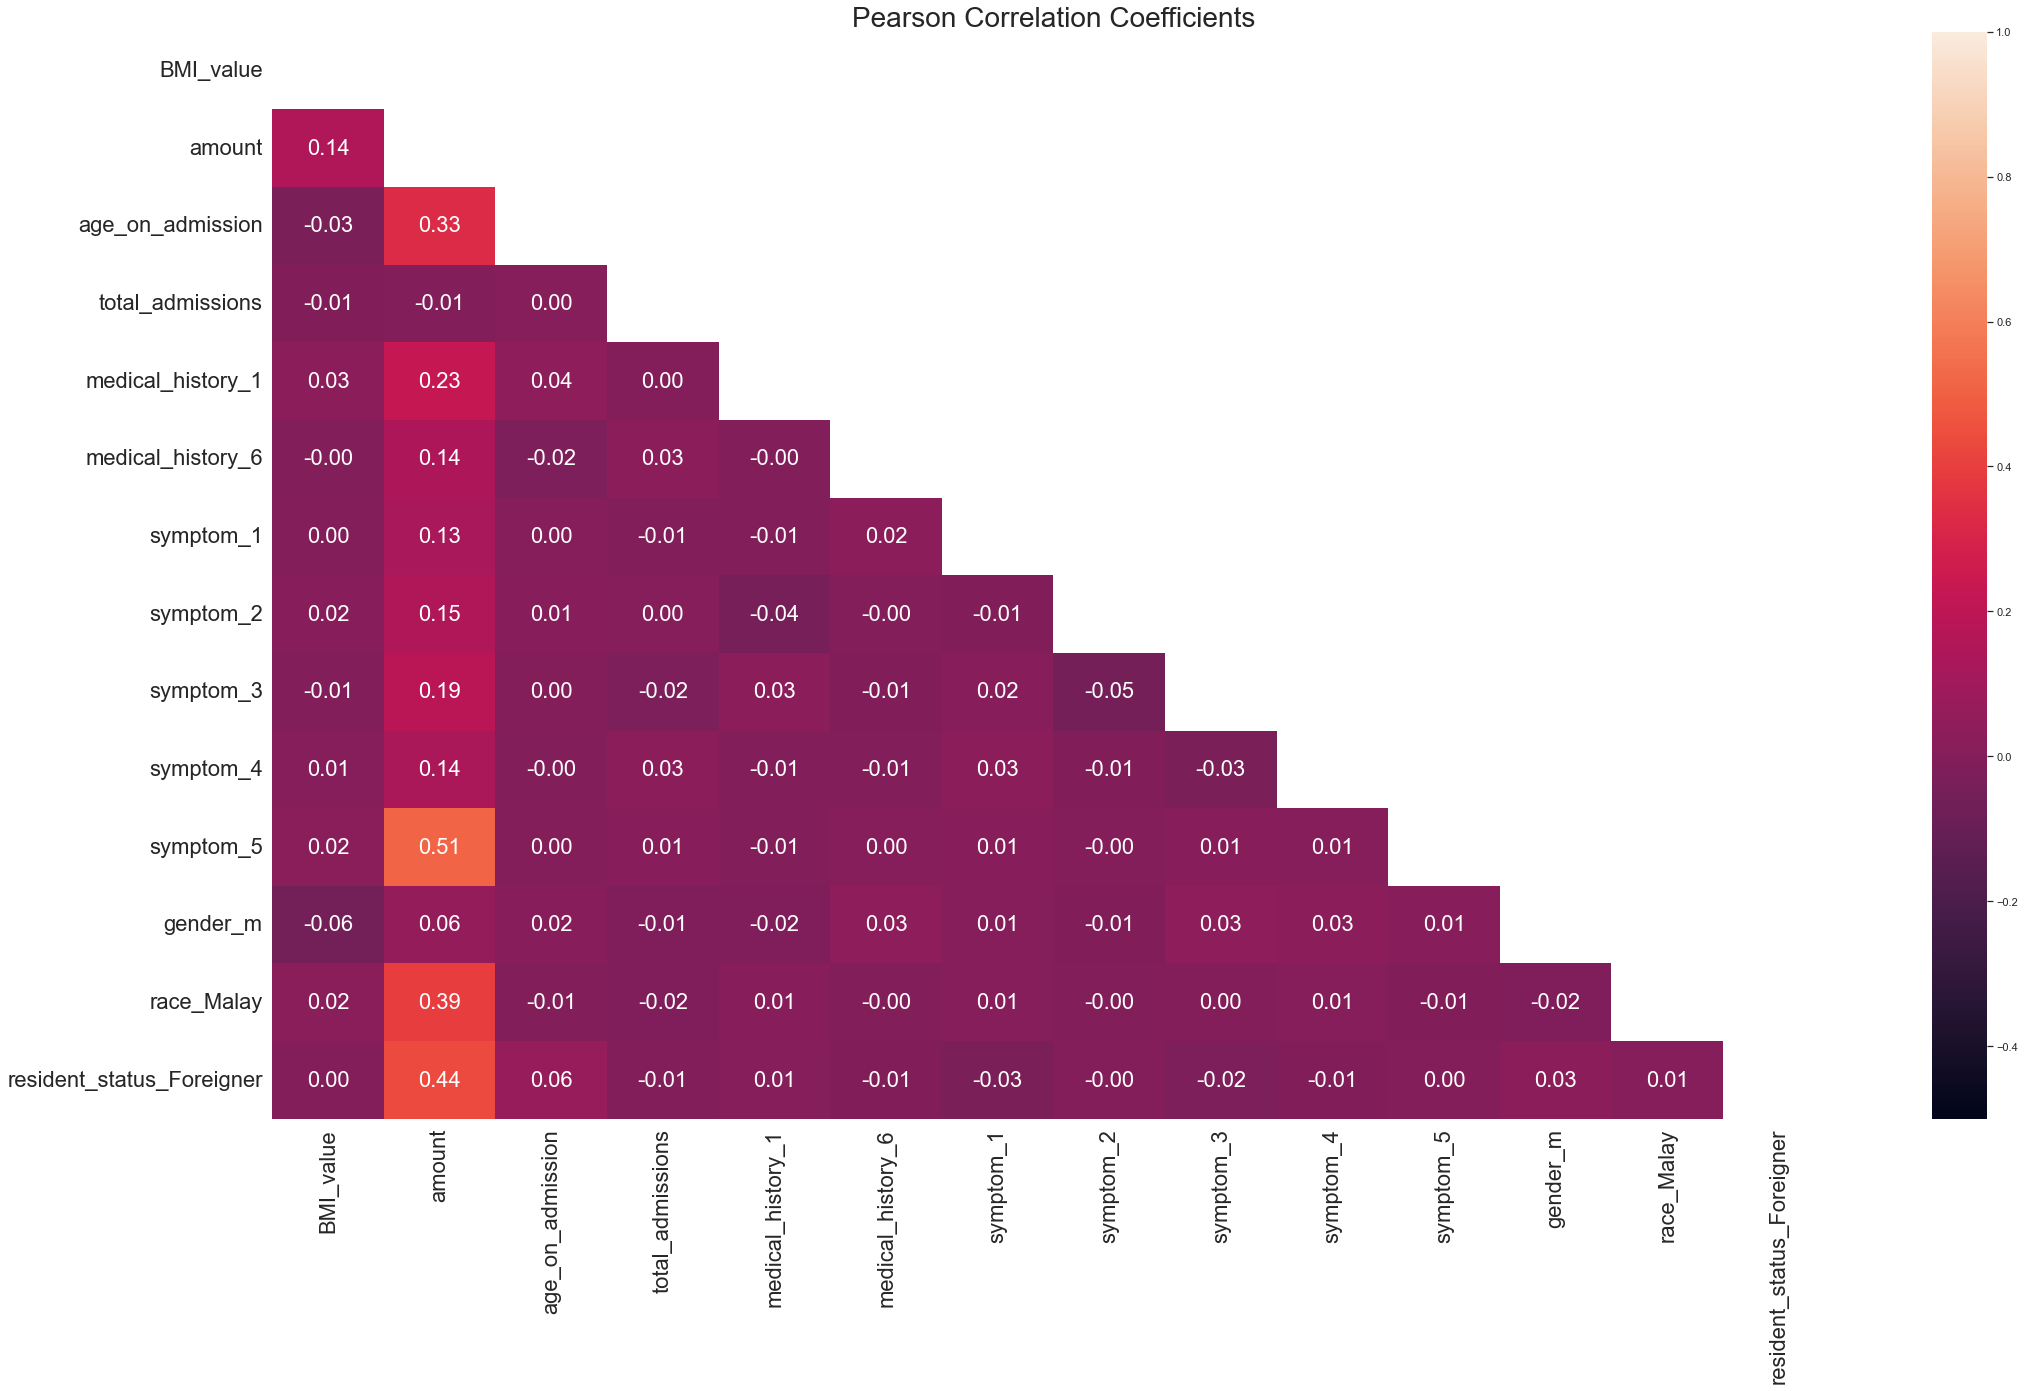

In [44]:
#selecting only some of the features to heatmap
some = df_dummies[['BMI_value', 'amount', 'age_on_admission', 'total_admissions', 'medical_history_1', 'medical_history_6', 'symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'gender_m', 'race_Malay', 'resident_status_Foreigner']]

# Pearson correlation matrix and heatmap: 
plt.figure(figsize=(35, 20))
mask = np.triu(np.ones_like(some.corr(), dtype=bool))
heatmap = sns.heatmap(some.corr(method = 'pearson'), annot=True, annot_kws={"size": 22}, fmt=".2f", mask = mask, vmin = -0.5, vmax = 1)
heatmap.set_title('Pearson Correlation Coefficients', fontdict={'fontsize':28}, pad=5)
heatmap.set_yticklabels(heatmap.get_xmajorticklabels(), fontsize = 22)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 22, rotation = 90);


From the Pearson correlation coefficients heatmap above, it should be noted that there was a weak positive correlation between amount and BMI_value, medical_history1, medical_history_6 and symptom_1-4. 

Moderate positive correlation was observed between amount and age_on_admission, race_Malay and resident_status_Foreigner.
There was strong positive correlation between amount and symptom_5.

In [45]:
def plot_boxplot(df, x, y, title):
    ax = sns.boxplot(x=x, y=y, data=df, palette = holmuskpalette_diverse)
    ax.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))
    ax.set_ylabel('cost(SGD)')
    ax.set_title(title, pad = 20, fontsize = 15)
    sns.despine()
    plt.show()

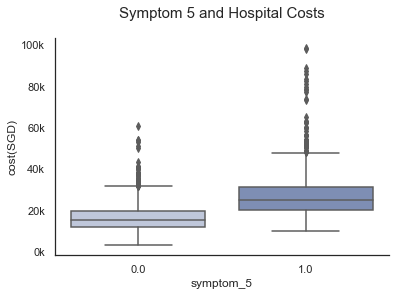

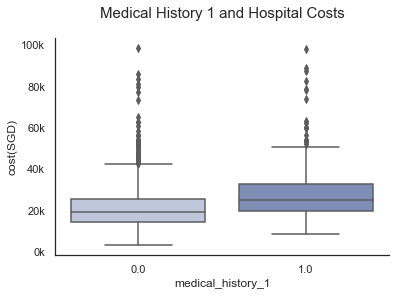

In [46]:
plot_boxplot(df, "symptom_5", "amount", 'Symptom 5 and Hospital Costs')
plot_boxplot(df, "medical_history_1", "amount", 'Medical History 1 and Hospital Costs')

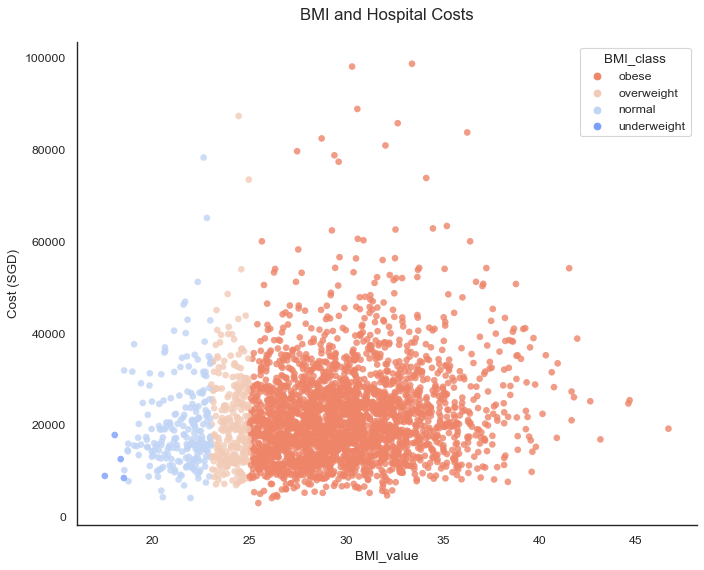

In [47]:
#BMI_value and amount 
plt.figure(figsize=(10, 8), dpi = 80)
ax = sns.scatterplot(data=df, x="BMI_value", y="amount", hue = 'BMI_class', palette='coolwarm_r', alpha = 0.8, linewidth=0)
ax.set_title('BMI and Hospital Costs', pad = 20, fontsize = 15)
ax.set_ylabel('Cost (SGD)')
sns.despine()

Above graph was plotted to study the relationship of BMI and hospital admission cost better. We can again see that the higher BMI value correlates with higher hospital admission costs. However, patients with the most highest BMI value aren't the most expensive.

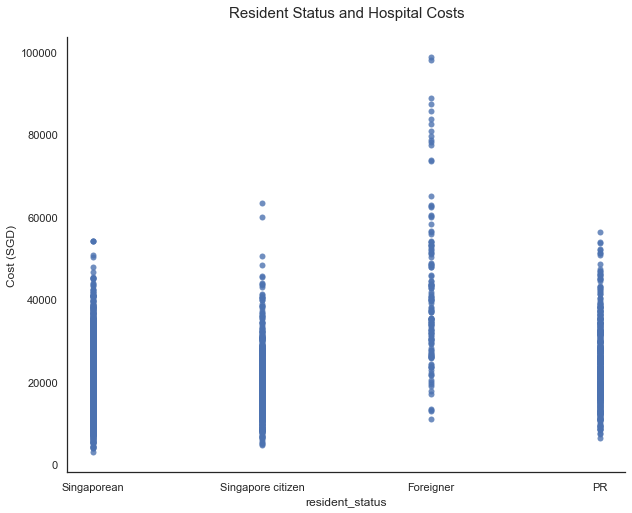

In [48]:
#resident status and hospital costs
plt.figure(figsize=(10, 8))
ax = sns.scatterplot(data=df, x="resident_status", y="amount", palette='coolwarm_r', alpha = 0.8, linewidth=0)
ax.set_title('Resident Status and Hospital Costs', pad = 20, fontsize = 15)
ax.set_ylabel('Cost (SGD)')
sns.despine()

Foregners had the most expensive hospital costs. Their average hospital admission costs were also higher than others'. This is most probably because of the different insurance and healthcare policies between the groups. 
Based on the plot above and formal definition 'citizen', we decided to put Singaporean, Singapore citizen and PR into same category. Let's define feature 'Singaporean': 

In [49]:
df['resident_status'] = df['resident_status'].replace(['Singaporean', 'Singapore citizen', 'PR'], 'Singaporean')

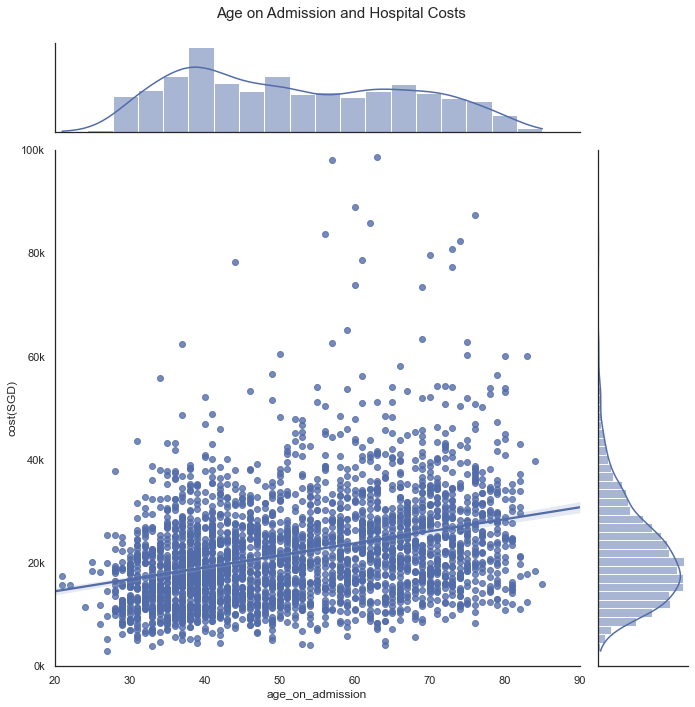

In [50]:
#Age on admission and amount 
sns.set_style("white", {'axes.grid' : False})

#plt.subplots(figsize=(20,20))    
g = sns.jointplot(x="age_on_admission", y="amount", data=df,
                  kind="reg", truncate=False,
                  xlim=(20, 90), ylim=(0, 100000), height = 10, color = holmuskblue3)

g.fig.suptitle('Age on Admission and Hospital Costs', fontsize = 15)
g.fig.subplots_adjust(top=0.93) 
g.ax_joint.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))
g.set_axis_labels("age_on_admission", "cost(SGD)", fontsize=12)

sns.despine()


The patients of the data were of age 21-85. Mean age of the patients was 51.9 years (std 14.7 years). From the above graph we can again see that age was positively correlated to hospital admission costs.

## Predictive Modelling: Frequent Hospital Admissions
What features on the first admission predict subsequent hospital admissions during the year of the first admission? We define frequent patient as a patient that is admitted again in a year after the first admission. Since the last record of the data is 28.12.2015, patients that are admitted after 28.12.2014 are excluded. Foreigners are excluded since their primary healthcare might not be in Singapore.

In [51]:
df.sort_values('date_of_admission', inplace = True) 

In [52]:
#create frequent patient feature
df['freq'] = 0
df['due_date'] = 0

freq_patients = []

for i, row in df.iterrows(): 
    patient = row.patient_id
    admission_date = row.date_of_admission
    due_date = row.date_of_admission + relativedelta(years=1)
    df['due_date'][i] = due_date
    exclude_date = datetime.strptime('2014-12-28', '%Y-%m-%d')
    subsequents = df[((df.patient_id == patient) & (df.date_of_admission<due_date) & (df.date_of_admission > admission_date))]
    #admissions after the first admission are excluded
    if patient in freq_patients: 
        df['freq'][i] = -1
    #frequent patient
    elif ((admission_date < due_date) & len(subsequents)>0):
        df['freq'][i] = 1
        freq_patients.append(patient)
    #excluded
    if admission_date > exclude_date: 
        df['freq'][i] = -1

df.drop('due_date', axis = 1, inplace = True)
    


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [53]:
data = df
data = data[data.freq >-1]
data = data[data.resident_status != 'Foreigner']

In [54]:
frequent_patients = data[data['freq']==1]
onetime_patients = data[data['freq']==0]
print('Number of patients:', len(data))
print('Number of patients that have multiple admissions: ', len(frequent_patients))
print('Number of patients that have single admission: ', len(onetime_patients))

Number of patients: 2112
Number of patients that have multiple admissions:  96
Number of patients that have single admission:  2016


In [55]:
frequent_patients.describe()

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0
mean,79.542708,165.677083,29.081241,50.468750,11.083333,2.145833,20836.286361,0.156250,0.302083,0.156250,0.062500,0.041667,0.270833,0.250000,0.562500,0.604167,0.802083,0.458333,0.854167,0.697917,0.625000,0.59375,0.604167,0.750000,0.572917,14.396875,27.323958,99.239583,1.0
std,10.580526,7.085188,4.238341,14.265861,2.886144,0.383314,8233.251788,0.364998,0.461571,0.364998,0.243332,0.200875,0.446723,0.435286,0.498682,0.491596,0.400520,0.500876,0.354792,0.461571,0.486664,0.49371,0.491596,0.435286,0.497251,1.693607,2.601811,14.068812,0.0
min,55.200000,151.000000,20.262593,29.000000,4.000000,2.000000,4949.806331,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,11.100000,20.100000,68.000000,1.0
25%,71.375000,161.000000,26.047675,38.000000,9.000000,2.000000,14963.670831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.750000,0.000000,13.100000,25.800000,90.000000,1.0
50%,79.300000,166.000000,29.456112,49.000000,11.000000,2.000000,20473.108810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,14.100000,27.200000,99.000000,1.0
75%,86.825000,171.000000,31.497526,64.250000,13.000000,2.000000,25137.077684,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.250000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,15.525000,29.225000,107.250000,1.0
max,107.800000,179.000000,41.540062,77.000000,18.000000,4.000000,54142.013597,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,18.100000,34.000000,133.000000,1.0


In [56]:
onetime_patients.describe()

,weight,height,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq
count,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.0
mean,78.810962,165.062996,28.989888,51.373016,11.051091,1.167659,20931.042481,0.169643,0.313988,0.142361,0.052579,0.065476,0.257937,0.253968,0.501488,0.594246,0.821429,0.513393,0.821429,0.750992,0.627976,0.665675,0.549107,0.728175,0.531746,14.459921,27.406895,99.581349,0.0
std,10.876831,7.066329,4.106212,14.710734,2.863628,0.403048,8634.248790,0.375412,0.464227,0.349507,0.223248,0.247426,0.437607,0.435388,0.500122,0.491159,0.383088,0.499945,0.383088,0.432546,0.483465,0.471871,0.497706,0.445011,0.499115,1.754167,2.511541,15.285872,0.0
min,48.000000,151.000000,18.022639,21.000000,1.000000,1.000000,2946.100354,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,57.000000,0.0
25%,71.400000,160.000000,26.269537,39.000000,9.000000,1.000000,14563.051690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.200000,25.700000,88.000000,0.0
50%,79.000000,165.000000,28.841370,49.000000,11.000000,1.000000,19698.759614,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.500000,27.400000,100.000000,0.0
75%,86.200000,171.000000,31.727719,64.000000,13.000000,1.000000,25851.131541,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.700000,29.200000,111.000000,0.0
max,115.200000,186.000000,44.667126,83.000000,20.000000,4.000000,60010.177658,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20.300000,35.100000,142.000000,0.0


In [57]:
o = pd.get_dummies(onetime_patients[['gender']])
f = pd.get_dummies(frequent_patients[['gender']])

#conduct t-tests to see if the groups differ 
cat1 = onetime_patients.amount
cat2 = frequent_patients.amount

print(ttest_ind(cat1, cat2))

Ttest_indResult(statistic=0.10527020806663427, pvalue=0.9161714080381067)


There was no statistically significant differences between the groups, in any of the features.

In [58]:
#save processed data
df.to_csv('preprocessed_data/data_preprocessed.csv', index=False)

### Logistic Regression Model

Building a simple logistic regression model to predict label (frequent_patient or not). We choose parameters based on correlation coefficients visualized in the heatmap previously. 


In [59]:
#drop some features and dummy code categorical variables
data = data.drop(['patient_id', 'date_of_admission', 'date_of_discharge', 'date_of_birth', 'total_admissions', 'weight', 'height', 'BMI_class', 'lab_result_1', 'lab_result_2', 'lab_result_3'], axis = 1)
data = pd.get_dummies(data, drop_first = True)
data.head()

,BMI_value,age_on_admission,length_of_stay,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,freq,gender_m,race_Indian,race_Malay,race_Other
1281,30.625000,32,10,23303.000924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,0,1,0
397,27.506655,34,10,15405.418665,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,1,1,0,0
1570,29.958678,74,16,17153.905421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1,0,0,0
2961,27.873961,43,12,27994.878530,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0
2644,31.577562,43,11,16813.123088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0,1,0,0


In [60]:
#train and test split 
x = data.drop('freq', axis = 1)
y = data['freq']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 25, shuffle = True)

print(f"training examples: {x_train.shape[0]}")
print(f"testing examples: {x_test.shape[0]}")

training examples: 1689
testing examples: 423


In [61]:
y_train.value_counts()

0    1608
1      81
Name: freq, dtype: int64

In [62]:
#measure training data unbalance and balance with SMOTE
n_freq = y_train.value_counts()[1]
print('Frequent patients in the data before balancing:', round(n_freq/len(y_train),4))

#normalize 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

oversample = SMOTE()
x_train_scaled_res, y_train_res = oversample.fit_resample(x_train_scaled, y_train)

n_freq = y_train_res.value_counts()[1]
print('Frequent patients in the data after balancing:', round(n_freq/len(y_train_res),4))

Frequent patients in the data before balancing: 0.048
Frequent patients in the data after balancing: 0.5


In [63]:
#fit model 
log_model = LogisticRegression(n_jobs = -1, multi_class='auto', penalty = 'l2')
log_model = log_model.fit(x_train_scaled_res, y_train_res)

In [64]:
#predictions
y_pred = log_model.predict(x_test_scaled)

In [65]:
y_test.value_counts()

0    408
1     15
Name: freq, dtype: int64

Text(0.5, 257.44, 'Predicted label')

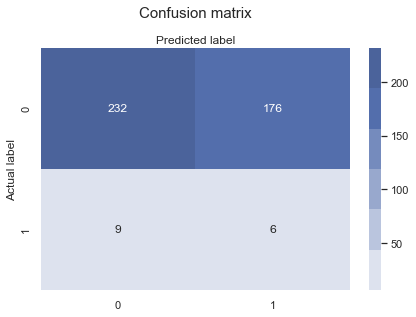

In [66]:
#Evaluation the performance: confusion matrix 
cnf_matrix = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots()
tick_marks = np.arange(2)

sns.heatmap(cnf_matrix, annot=True, cmap = holmuskpalette_light, fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, fontsize = 15)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

As we can see, model performance could be better. Model performance could be further improved with larger data and tuning the parameters further. Since the data sampling method is unknown, it is possible that the data doesn't have all the subsequent admissions and because of this type of modeling is dependent on longitudinal data, the results should be taken with reservation. 

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


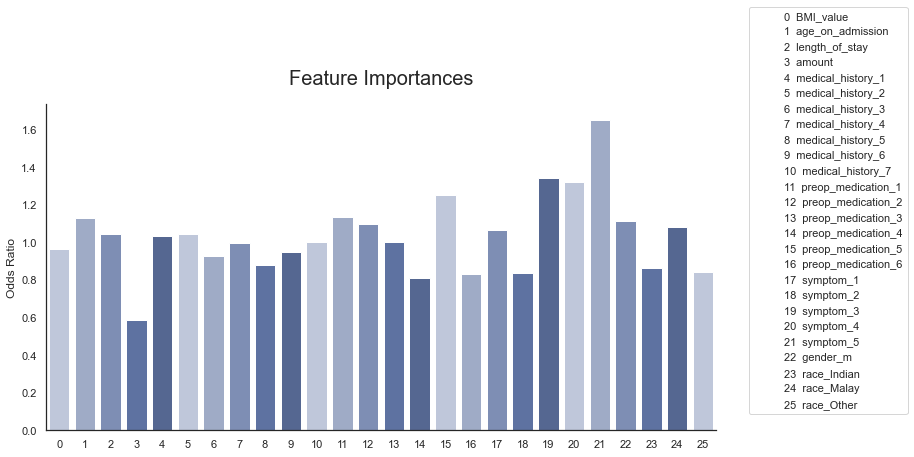

In [67]:
#Feature Importances (log odds), transformed to odd ratios
importance = log_model.coef_[0]
importance = np.exp(importance)

fig, ax = plt.subplots(figsize = (12, 6))

labels = []
for i,v in enumerate(importance):
    #print('Feature: %0d, Score: %.5f' % (i,v), x_train.columns[i])
    labels.append(str(i) + '  ' + x_train.columns[i])
    
ax = sns.barplot([x for x in range(len(importance))], importance, palette=holmuskpalette_light[1:])
ax.set(ylabel='Odds Ratio', xlabel = None)
ax.set_title('Feature Importances', fontsize = 20, pad = 20)
ax.grid(False)

plt.legend(loc=(1.05, 0.05), labels=labels, markerscale = 0)
leg = plt.gca().get_legend()
for item in leg.legendHandles:
    item.set_visible(False)
    
sns.despine()

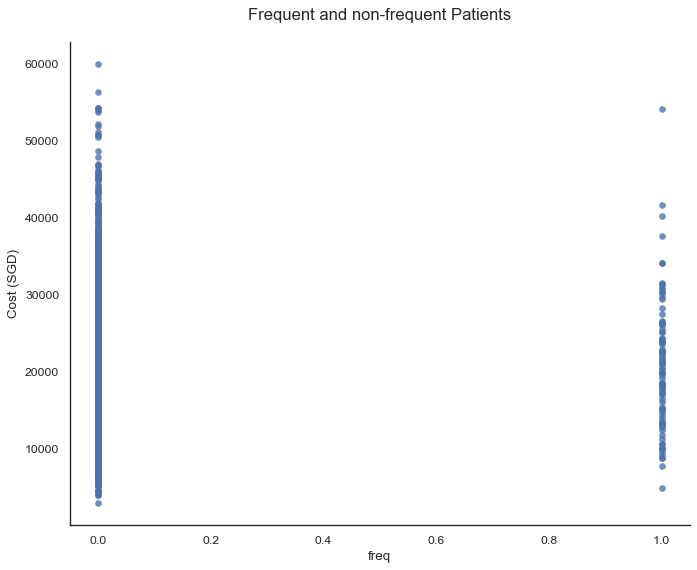

In [68]:
#plot admission cost from frequents and non-frequents 

plt.figure(figsize=(10, 8), dpi = 80)
ax = sns.scatterplot(data=data, x="freq", y="amount",  palette='coolwarm_r', alpha = 0.8, linewidth=0)
ax.set_title('Frequent and non-frequent Patients', pad = 20, fontsize = 15)
ax.set_ylabel('Cost (SGD)')
sns.despine()

## Predictive Modelling: Hospital Costs

Which features explain higher hospital costs? 


### Random Forest Regression Model

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression.  
Random Forest Regression uses Bootstrap Aggregation (Bagging): Each decision tree runs independently and at the end the outputs are aggregated by average. 

We chose Random Model Regressor to predict hospital costs (feature 'amount'), since it is often good for non-linear data to predict continuous labels. It is also not easy to overfit due to subset and feature randomization.

Pipeline is formed to normalize the data, select the best features and train the model. Grid search is used to choose the best features for the model and to tune the Random forest regression model parameters criterion, max_depth, max_features and n_estimators. 

In [69]:
#drop non-useful and redundant features and dummy code categorical data
data = df
data.drop(['patient_id', 'date_of_admission', 'date_of_discharge', 'date_of_birth', 'weight', 'height', 'BMI_class'], axis = 1, inplace = True)
data = pd.get_dummies(data, drop_first = True)
data.head()

,BMI_value,age_on_admission,length_of_stay,total_admissions,amount,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,preop_medication_5,preop_medication_6,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,freq,gender_m,race_Indian,race_Malay,race_Other,resident_status_Singaporean
1281,30.625000,32,10,1,23303.000924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,13.8,22.6,89.0,0,0,0,1,0,1
397,27.506655,34,10,2,15405.418665,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,13.2,30.9,123.0,0,1,1,0,0,1
1570,29.958678,74,16,1,17153.905421,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,12.1,23.6,109.0,0,1,0,0,0,1
2961,27.873961,43,12,1,27994.878530,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,13.3,28.4,76.0,0,0,0,0,0,1
2644,31.577562,43,11,2,16813.123088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,11.2,26.2,100.0,0,0,1,0,0,1


In [70]:
#train data (90% of the data) and val data (20% of the data)
x = data.drop('amount', axis = 1)
y = data['amount']

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 25, shuffle = True)

print(f"training examples: {x_train.shape[0]}")
print(f"testing examples: {x_val.shape[0]}")

training examples: 2318
testing examples: 580


In [71]:
scaler = StandardScaler()

In [72]:
#pipeline and model fitting
pipe = make_pipeline(scaler, SelectKBest(mutual_info_regression), RandomForestRegressor(random_state = 25))
pipe.get_params().keys()

params = {
    'selectkbest__k': [20], #[15, 20, 25]
    'randomforestregressor__criterion': ['squared_error'], 
    'randomforestregressor__max_depth' : [15], #[10, 12, 15]
    'randomforestregressor__max_features': ['auto'], #['auto', 'sqrt']
    'randomforestregressor__n_estimators' : [1200] #[900, 1100, 1200]
}

In [73]:
gs = GridSearchCV(pipe, params, n_jobs=-1, cv=7, return_train_score=True, refit = True)
gs.fit(x_train, y_train)
gs.best_params_

{'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__max_depth': 15,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__n_estimators': 1200,
 'selectkbest__k': 20}

In [74]:
#performance metrics
def evaluate(model, x_vali, y_vali, y_preds):
    print('Model Performance:')
    print('Root Mean Squared Error (RMSE): {:0.4f}'.format(np.sqrt(mean_squared_error(y_vali, y_preds))))
    print('Mean Absolute Error (MAE): {:0.4f}'.format(mean_absolute_error(y_vali, y_preds)))
    print('Explained variance score: {:0.4f}'.format(explained_variance_score(y_vali, y_preds)))

In [75]:
# MAE of predicting always mean of 'amount'
baseline_preds = data.amount.mean()
baseline_errors = abs(baseline_preds - y)
print('Mean Average error (MAE) of predicting always mean: {:0.4f}'.format(baseline_errors.mean()))

Mean Average error (MAE) of predicting always mean: 7602.0338


In [76]:
#baseline model (RandomForestRegressor with default parameter values)
base_model = RandomForestRegressor(random_state = 30)
base_model = base_model.fit(x_train, y_train)
base_y_pred = base_model.predict(x_val)
evaluate(base_model, x_val, y_val, base_y_pred)

Model Performance:
Root Mean Squared Error (RMSE): 3387.8401
Mean Absolute Error (MAE): 2371.7308
Explained variance score: 0.8893


In [77]:
#evaluate the tuned model
y_pred = gs.predict(x_val)
evaluate(gs, x_val, y_val, y_pred)

Model Performance:
Root Mean Squared Error (RMSE): 3237.4022
Mean Absolute Error (MAE): 2264.6037
Explained variance score: 0.8989


In [78]:
#metrics of the best model during training
best_metrics= pd.DataFrame(gs.cv_results_)
best_metrics = best_metrics[best_metrics.rank_test_score ==1]

#mean training r2
print('Mean Train r2 {:0.4f}'.format(best_metrics['mean_train_score'][0]))

Mean Train r2 0.9824


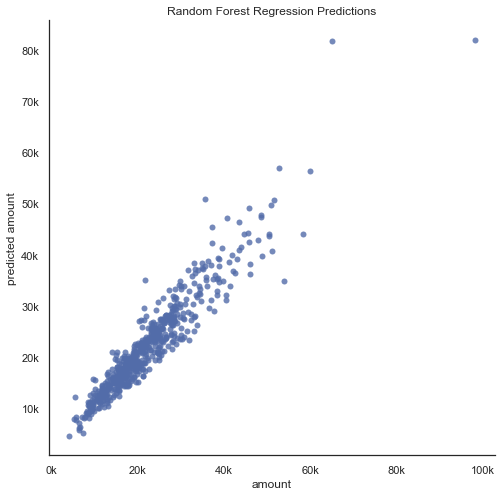

In [79]:
#plotting the predictions vs correct values on unseen data: 
y_pred = gs.predict(x_val)
plt.figure(figsize=(8, 8))
g = sns.scatterplot(x=y_val, y=y_pred, color = holmuskblue3, alpha = 0.8, linewidth=0)
g.set_title('Random Forest Regression Predictions')
g.set_xlabel('amount')
g.set_ylabel('predicted amount')

g.xaxis.set_major_formatter(FuncFormatter(monetary_ticks))
g.yaxis.set_major_formatter(FuncFormatter(monetary_ticks))

sns.despine()
plt.show() 

#### Feature Importances 

In [80]:
chosen_feat_nos = gs.best_estimator_.named_steps['selectkbest'].get_support(indices = True)
chosen_feats = x_train.columns[chosen_feat_nos].to_list()
feature_importances = list(gs.best_estimator_._final_estimator.feature_importances_)

In [81]:
feat_imp = pd.DataFrame()
feat_imp['feature'] = chosen_feats
chosen_feat_importances = feature_importances
feat_imp['importance'] = chosen_feat_importances
feat_imp.sort_values(by= 'importance', ascending=False, inplace = True)
feat_imp

,feature,importance
14,symptom_5,0.256054
19,resident_status_Singaporean,0.203404
18,race_Malay,0.179528
1,age_on_admission,0.124456
3,medical_history_1,0.044803
0,BMI_value,0.039560
12,symptom_3,0.024350
5,medical_history_6,0.022457
15,lab_result_2,0.019087
11,symptom_2,0.018882


The Random Forest Regression model was able to predict hospital admission costs quite well. The final model was able to explain 0.90 of the variance in the data. Root mean squared error of the final model was 3,2k SGD. 
Feature importances were measured as Gini importance (normalized total reduction of the criterion brought by a feature). The three most important features to predict the hospital admission costs were symptom 5, resident status Singaporean and race Malay. 